### Importing libraries

In [1]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from keras import datasets, layers, models
from sklearn.metrics import confusion_matrix

# Dataset Preprocessing

### Function to populate the an array with images

In [2]:
# NOTE: Ideally use the whole dataset, but due to hardware limitations there is an option to use less

# opens a directory with classes sorted into subdirectories, then populates the list of images and labels
def populate_set(dir: str):
    images = []
    labels = []
    # get subdirectory name and loop through it
    for category in os.listdir(dir):
        path = os.path.join(dir, category)
        # drop some items
        drop = 0
        # get the file inside the subdirectory and loop through it
        for filename in os.listdir(path):
            # use the fraction amount
            if ( drop == 0):
                # read the image and check if its valid
                img = cv.imread(os.path.join(path, filename))
                if img is not None:
                    # resize to ensure the images are correct dimensions
                    img = cv.resize(img, (224,224), interpolation= cv.INTER_LINEAR)
                    # reverse the order of the colour scheme to be RGB
                    img = img[:,:, ::-1]
                    # add image
                    images.append(img)
                    # add label
                    labels.append(category)
            # increment drop
            drop = (drop + 1) % 4      # choose ( 1/x * 100)% of the data to use 
    return np.array(images), np.array(labels, dtype=str)

# checks all the subdirectories which are labeled and returns a list of classes
def get_categories(dir: str):
    categories = []
    # get subdirectory name and loop through it
    for category in os.listdir(dir):
        categories.append(category)
    return categories      

### Populate the arrays with image information

In [3]:
# Get the relative directory for training and test data
valid_dir = "../imgs/validation"
train_dir = "../imgs/train"
test_dir = "../imgs/test"

# get training data
train_img, train_lab = populate_set(train_dir)

# get validation data
valid_img, valid_lab = populate_set(valid_dir)

# get testing data
test_img, test_lab = populate_set(test_dir)

# get list of categories
categories = get_categories(train_dir)

### Normalize and reorder data

In [4]:
# normalize the color values
train_img, test_img = train_img/255 , test_img/255

# get indices from 0-data size in random order; seed for repeatability
np.random.seed(seed=0)
train_indx = np.random.permutation(train_img.shape[0])

# shuffle training data
train_img = train_img[train_indx]
train_lab = train_lab[train_indx]


### Displaying images and their labels from training set

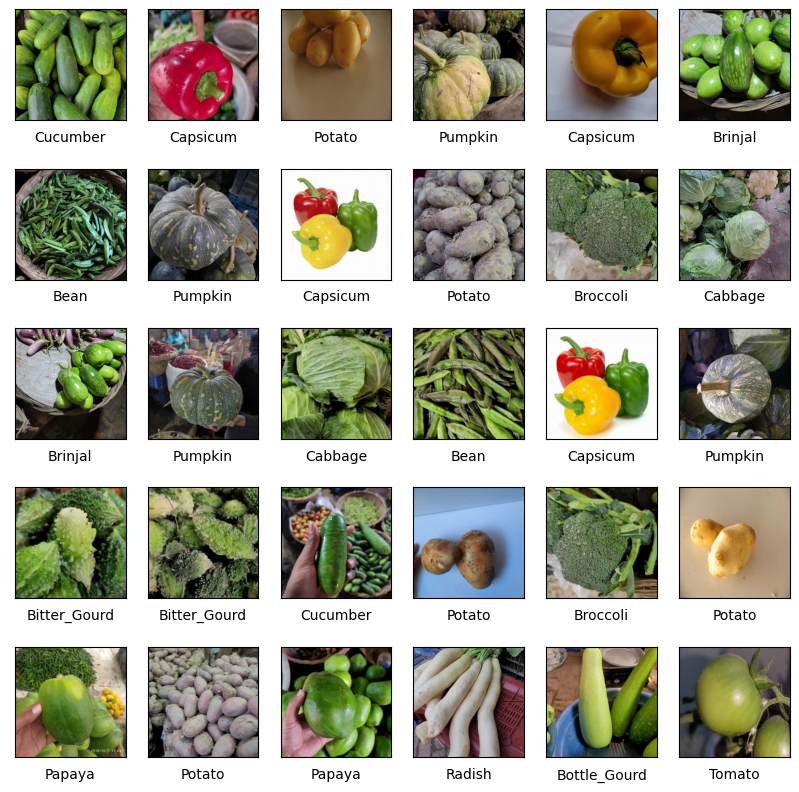

In [5]:
# set each figure to be 10x10
plt.figure(figsize=(10,10))

# show the training dataset
for i in range(30):
    # create a subplot for 30 sections
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # display the image
    plt.imshow(train_img[i])
    # display the label
    plt.xlabel(train_lab[i])

# display the dataset inside
plt.show()

### Encode the labels to one hot encoding

In [6]:
# Convert all the labels to integers
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(categories)

# Encode the training into one_hot scheme
train_lab = label_encoder.transform(train_lab)
train_one_hot = tf.one_hot(train_lab, 15)

# Encode the validation set into one_hot scheme
valid_lab = label_encoder.transform(valid_lab)
valid_one_hot = tf.one_hot(valid_lab, 15)

# Encode the integers into one_hot scheme
test_lab = label_encoder.transform(test_lab)
test_one_hot = tf.one_hot(test_lab, 15)


# Create Neural Network Model

### Create a CNN model

In [7]:
# using sequential model
model = models.Sequential([
    # Feature Extraction - convolution -> pool
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening layer
    layers.Flatten(),
    
    # Dense layers
    layers.Dense(64, activation='sigmoid'),
    layers.Dropout(0.3),
    layers.Dense(15, activation='softmax')
])

# display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

### Compile and train the CNN model

In [8]:
# configure the model for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004), 
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# train the model and save the history of training
history = model.fit(train_img, train_one_hot, validation_data=(valid_img, valid_one_hot), epochs=10)

Epoch 1/10
118/118 [==============================] - 10s 42ms/step - loss: 2.1612 - accuracy: 0.3048 - val_loss: 1.6957 - val_accuracy: 0.4920
Epoch 2/10
118/118 [==============================] - 4s 37ms/step - loss: 1.4518 - accuracy: 0.5891 - val_loss: 1.3360 - val_accuracy: 0.6267
Epoch 3/10
118/118 [==============================] - 4s 37ms/step - loss: 1.1359 - accuracy: 0.7091 - val_loss: 1.4596 - val_accuracy: 0.5467
Epoch 4/10
118/118 [==============================] - 4s 37ms/step - loss: 0.9224 - accuracy: 0.7803 - val_loss: 1.3611 - val_accuracy: 0.5587
Epoch 5/10
118/118 [==============================] - 4s 37ms/step - loss: 0.7454 - accuracy: 0.8368 - val_loss: 1.3216 - val_accuracy: 0.5733
Epoch 6/10
118/118 [==============================] - 4s 37ms/step - loss: 0.6035 - accuracy: 0.8797 - val_loss: 1.1602 - val_accuracy: 0.6320
Epoch 7/10
118/118 [==============================] - 4s 38ms/step - loss: 0.4888 - accuracy: 0.9216 - val_loss: 1.1758 - val_accuracy: 0.610

### Show training performance

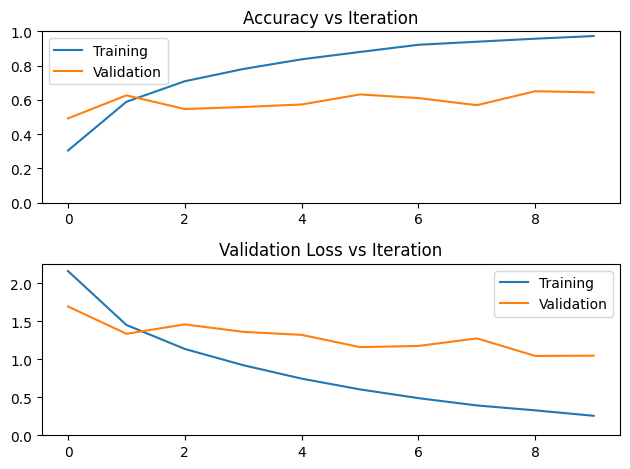

In [9]:
fig, axs = plt.subplots(2,1)

# Create accuracy plot
axs[0].plot(history.history['accuracy'], label="Training")
axs[0].set_title("Accuracy vs Iteration")

# Create Validation Accuracy plot
axs[0].plot(history.history['val_accuracy'], label="Validation")
axs[0].set_title("Accuracy vs Iteration")

axs[0].legend(loc='upper left')
axs[0].set_ylim([0,1])

# Create loss plot
axs[1].plot(history.history['loss'], label="Training")
axs[1].set_title("Loss vs Iteration")

# Create Validation loss plot
axs[1].plot(history.history['val_loss'], label="Validation")
axs[1].set_title("Validation Loss vs Iteration")
axs[1].legend(loc='upper right')
axs[1].set_ylim(ymin=0)

fig.tight_layout()

# Test the model

### Test using test dataset

In [10]:
# model makes prediction
prediction = model.predict(test_img)

# decode from one hot encoding which returns an array of ints
pred = np.argmax(prediction, axis=1)

# create a confusion matrix
matrix = confusion_matrix(test_lab, pred)

24/24 [==============================] - 0s 14ms/step


### Plot data from tests

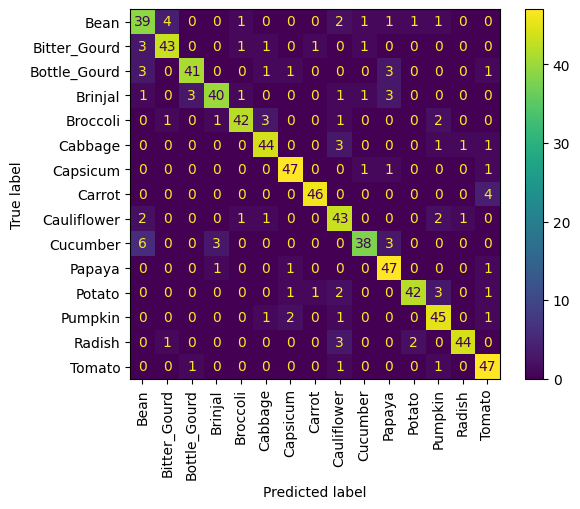

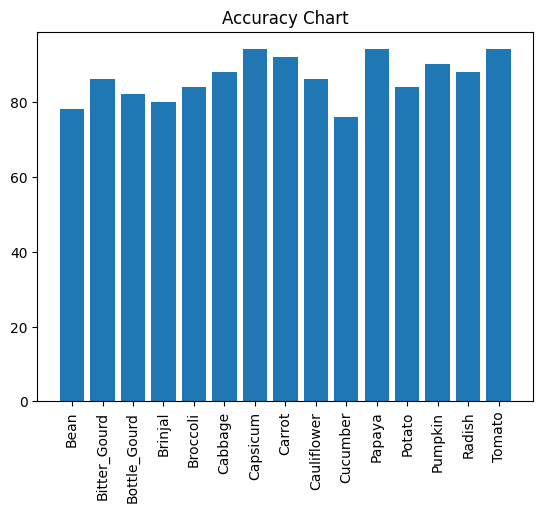

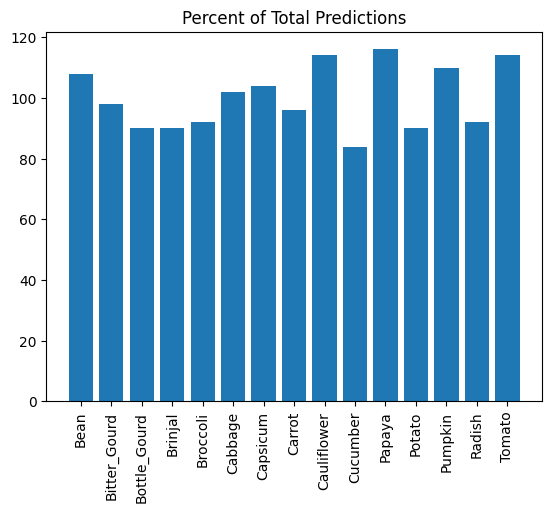

Accuracy: 86.4%


In [11]:
# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels= categories)
cm_display.plot(xticks_rotation='vertical')
plt.show()

# Calculate Accuracy for each category
accuracy = matrix.diagonal()/matrix.sum(axis=1)

# plot accuracy for each category
fig, ax = plt.subplots()
ax.bar(categories, accuracy*100)
ax.set_title("Accuracy Chart")
ax.tick_params(axis='x', rotation=90)
plt.show()

predicted = matrix.sum(axis=0) / (matrix.sum(axis=1)) * 100
fig, ax = plt.subplots()
ax.bar(categories, predicted)
ax.set_title("Percent of Total Predictions")
ax.tick_params(axis='x', rotation=90)
plt.show()

total_acc = accuracy.sum()/len(accuracy)*100
print("Accuracy: " + str(total_acc) + "%")

### Test Personal Images

In [12]:
# Get images directory
path = './images'
images = []
labels = []

# Read in each image and resize all of them
for filename in os.listdir(path):
    # read the image and check if its valid
    img = cv.imread(os.path.join(path, filename))
    if img is not None:
        img = cv.resize(img, (224,224), interpolation= cv.INTER_LINEAR)
        # reverse the order of the colour scheme to be RGB
        img = img[:,:, ::-1]
        # add image
        images.append(img)
        # add label
        labels.append(filename)

# convert to numpy array
images = np.array(images)

# normalize colour values
images = images/255
labels = np.array(labels)
# model makes prediction
prediction = model.predict(images)

# decode from one hot encoding which returns an array of ints
pred = np.argmax(prediction, axis=1)

1/1 [==============================] - 0s 29ms/step


### Plot results of personal data

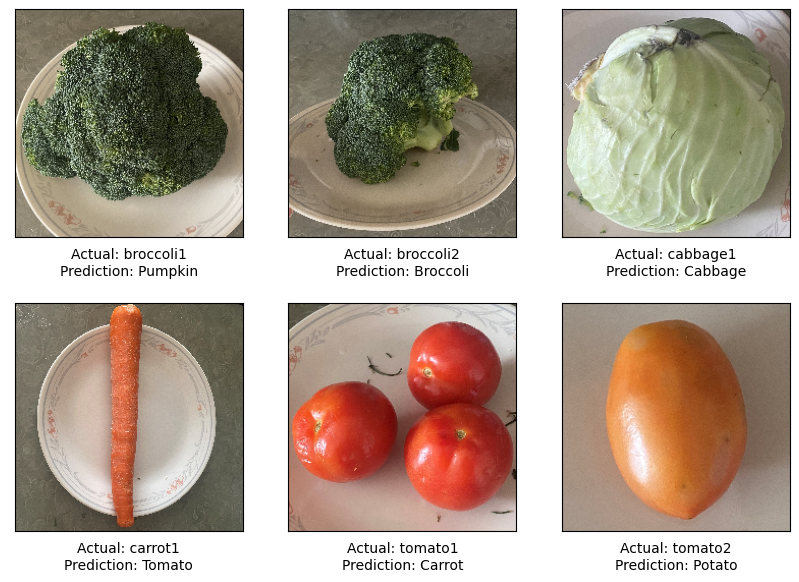

In [13]:
# set each figure to be 10x10
plt.figure(figsize=(10,7))

# show the training dataset
for i in range(images.shape[0]):
    # create a subplot for 30 sections
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # display the image
    plt.imshow(images[i])
    # display the label
    caption = "Actual: "+labels[i] + "\n" +"Prediction: "+ categories[pred[i]]
    caption = caption.replace(".JPG", "")
    plt.xlabel(caption)
    
plt.show()